# CS4487 - Machine Learning
# Lecture 3a - Linear Classifiers
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
1. Discriminative linear classifiers
2. Logistic regression
3. Support vector machines (SVM)

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


# Classification with Generative Model
- Steps to build a classifier
  1. Collect training data (features $\mathbf{x}$ and class labels $y$)
  2. Learn class-conditional distribution (CCD), $p(\mathbf{x}|y)$.
  3. Use Bayes' rule to calculate class probability, $p(y|\mathbf{x})$.
- **Note:** the data is used to learn the CCD -- the classifier is secondary.
  - Density estimation is an "ill-posed" problem -- which density to use?  how much data is needed?

- Advice from Vladimir Vapnik (inventor of SVM):
> When solving a problem, try to avoid solving a more general problem as an intermediate step.

- **Discriminative solution**
  - Solve for the classifier $p(y|\mathbf{x})$ directly!

- Terminology
  - **"Discriminative"** - learn to directly discriminate the classes apart using the features.
  - **"Generative"** - learn model of how the features are generated from different classes.

# Linear Classifier
- **Setup**
  - Observation (feature vectors) $\mathbf{x}\in \mathbb{R}^d$
  - Class $y \in \{-1, +1\}$
- **Goal**: given a feature vector $\mathbf{x}$, predict its class $y$.
  - Calculate a _linear function_ of the feature vector $\mathbf{x}$.
    - $f(\mathbf{x}) = \mathbf{w}^T \mathbf{x} + b = \sum_{j=1}^d w_j x_j + b$
      - $\mathbf{w}\in \mathbb{R}^d$ are the weights of the linear function.
      - multiply each feature value with a weight, and then add together.
  - Predict from the value:
    - if $f(\mathbf{x}) > 0$ then predict Class $y=1$
    - if $f(\mathbf{x}) < 0$ then predict Class $y=-1$
    - Equivalently, $y = \mathrm{sign}(f(\mathbf{x}))$

# Geometric Interpretation
- The linear classifier separates the features space into 2 _half-spaces_
  - corresponding to feature values belonging to Class +1 and Class -1
  - the class boundary is normal to $\mathbf{w}$.
    - also called the _separating hyperplane_.

  - Example: $\mathbf{w} = \begin{bmatrix}2\\1\end{bmatrix}$, $b=0$

In [2]:
def drawplane(w, b, wlabel=None, poscol=None, negcol=None):
    # w^Tx + b = 0
    # w0 x0 + w1 x1 + b = 0
    # x1 = -w0/w1 x0 - b / w1

    # the line
    x0 = linspace(-10,10)
    x1 = -w[0]/w[1] * x0 - b / w[1]
    
    
    # fill positive half-space or neg space
    if (poscol):
        polyx = [x0[0], x0[-1], x0[-1], x0[0]]
        polyy = [x1[0], x1[-1], x1[0], x1[0]]
        plt.fill(polyx, polyy, poscol, alpha=0.2)
    
    if (negcol):
        polyx = [x0[0], x0[-1], x0[0], x0[0]]
        polyy = [x1[0], x1[-1], x1[-1], x1[0]]
        plt.fill(polyx, polyy, negcol, alpha=0.2)
        
    # plot line
    plt.plot(x0, x1, 'k-', lw=2)

    # the w
    if (wlabel):
        xp = array([0, -b/w[1]])
        xpw = xp+w
        plt.arrow(xp[0], xp[1], w[0], w[1], width=0.01)
        plt.text(xpw[0]-0.5, xpw[1], wlabel)
    

In [3]:
linclass = plt.figure()
w = array([2, 1])
b = 0;

drawplane(w, b, '$\mathbf{w}$', 'b', 'r')

# a few points
plt.plot([2.2,4,3], [-2,2,-1], 'bx')
plt.plot([-2.2,-4,-3], [2,1,-1], 'ro')

plt.text(-1.8,4, "$f(\mathbf{x}) = 0$", fontsize=12)
plt.text(4, 3.5, "$f(\mathbf{x})>0$\nclass +1", ha="right", fontsize=12)
plt.text(-4, -3.5, "$f(\mathbf{x})<0$\nclass -1", fontsize=12)

plt.xlabel('feature $x_1$'); plt.ylabel('feature $x_2$')
plt.axis('equal')
plt.axis([-5, 5, -5, 5]); plt.grid(True)
plt.close()

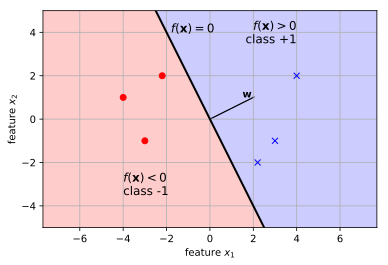

In [4]:
linclass

# Separating Hyperplane
- In a $d$-dimensional feature space, the parameters are $\mathbf{w}\in\mathbb{R}^d$.
- The equation $\mathbf{w}^T\mathbf{x} + b = 0$ defines a $(d-1)$-dim. linear surface:
  - for $d=2$, $\mathbf{w}$ defines a 1-D line.
  - for $d=3$, $\mathbf{w}$ defines a 2-D plane.
  - ...
  - in general, we call it a hyperplane.


# Learning the classifier
- How to set the classifier parameters $(\mathbf{w}, b)$?
  - Learn them from training data!
- Classifiers differ in the objectives used to learn the parameters $(\mathbf{w},b)$.
  - We will look at two examples:
    - _logistic regression_
    - _support vector machine (SVM)_

# Logistic regression
- Use a probabilistic approach
- Need to map the function values $f(\mathbf{x}) = \mathbf{w}^T\mathbf{x} + b$ to probability values between 0 and 1.
  - _sigmoid_ function maps from real number to interval [0,1]
  - $\sigma(z) = \frac{1}{1+e^{-z}}$

In [5]:
z = linspace(-5,5)
sigz = 1/(1+exp(-z))

sigmoidplot = plt.figure(figsize=(5,3))

plt.plot(z,sigz, 'b-')

plt.xlabel('$f(\mathbf{x})$'); plt.ylabel('$\sigma(f(\mathbf{x}))$')
plt.axis([-5, 5, 0, 1]); plt.grid(True)
plt.close()

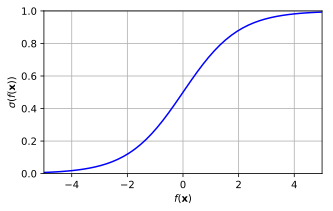

In [6]:
sigmoidplot

- Given a feature vector $x$, the probability of a class is:
  - $p(y=+1|\mathbf{x}) = \sigma( f(\mathbf{x}) )$
  - $p(y=-1|\mathbf{x}) = 1-\sigma( f(\mathbf{x}) )$
- Note: here we are directly modeling the class posterior probability!
  - not the class-conditional $p(\mathbf{x}|y)$

In [7]:
x = linspace(-10,10, 100)
w = 2.0
b = -4.0
f = w*x+b
sf = 1/(1+exp(-f))
midx = -b/w

lrexample = plt.figure(figsize=(6,3))

plt.plot(x,sf, 'b-', label="$p(y=+1|\mathbf{x})$")
plt.plot(x,1-sf, 'r-', label="$p(y=-1|\mathbf{x})$")
plt.plot([midx, midx], [0.0,1.2], 'k--', label="decision boundary")

plt.arrow(midx-0.1,1.05,-1.8,0,width=0.01)
plt.arrow(midx+0.1,1.05,1.8,0,width=0.01)
plt.text(midx+0.2,1.10,"Class +1")
plt.text(midx-0.2,1.10,"Class -1", horizontalalignment='right')
plt.legend(loc=0, framealpha=1, fontsize='medium')
plt.title('class posterior $p(y|\mathbf{x})$');
plt.xlabel('feature $\mathbf{x}$'); plt.ylabel('probability')
plt.axis([-7, 7, 0, 1.2]); plt.grid(True)
plt.close()

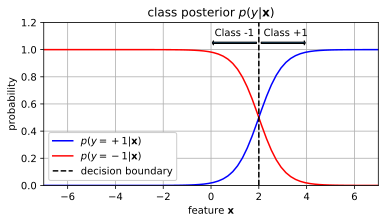

In [8]:
lrexample

# Learning the parameters
- Given training data $\{\mathbf{x}_i,y_i\}_{i=1}^N$, learn the function parameters $(\mathbf{w},b)$ using maximum likelihood estimation.
- maximize the likelihood of the data $\{\mathbf{x}_i,y_i\}$:
  $$(\mathbf{w}^*,b^*) = \mathop{\mathrm{argmax}}_{\mathbf{w},b} \sum_{i=1}^N \log p(y_i|\mathbf{x}_i)$$

- to prevent _overfitting_, add a prior distribution on $\mathbf{w}$.
  - assume Gaussian distribution on $\mathbf{w}$ with variance $1/C$
  $$(\mathbf{w}^*,b^*) = \mathop{\mathrm{argmax}}_{\mathbf{w},b} \log p(\mathbf{w}) + \sum_{i=1}^N \log p(y_i|\mathbf{x}_i)$$

- Equivalently, 
  $$(\mathbf{w}^*,b^*) = \mathop{\mathrm{argmin}}_{\mathbf{w},b} \frac{1}{C} \mathbf{w}^T\mathbf{w} + \sum_{i=1}^N \log (1+\exp(-y_i (\mathbf{w}^T \mathbf{x}_i+b)))$$
- the first term is the _regularization term_
  - Note: $\mathbf{w}^T\mathbf{w} = \sum_{j=1}^d w_j^2$
  - penalty term that keeps entries in $\mathbf{w}$ from getting too large.
  - $C$ is the regularization _hyperparameter_
    - larger $C$ value allow large values in $\mathbf{w}$.
    - smaller $C$ value discourage large values in $\mathbf{w}$.

  $$(\mathbf{w}^*,b^*) = \mathop{\mathrm{argmin}}_{\mathbf{w},b} \frac{1}{C} \mathbf{w}^T\mathbf{w} + \sum_{i=1}^N \log (1+\exp(-y_i (\mathbf{w}^T \mathbf{x}_i+b)))$$


- the second term is the _data-fit term_
    - wants to make the parameters $(\mathbf{w},b)$ to well fit the data.
    - Define $z_i = y_i f(\mathbf{x}_i)$
      - Interesing observation:
        - $z_i > 0$ when sample $\mathbf{x}_i$ is classified correctly
        - $z_i < 0$ when sample $\mathbf{x}_i$ is classified incorrectly
        - $z_i = 0$ when sample is on classifier boundary
    - logistic loss function: $L(z_i) = \log (1+\exp(-z_i))$

In [9]:
z = linspace(-6,6,100)
logloss = log(1+exp(-z)) / log(2)
lossfig = plt.figure()
plt.plot(z,logloss, 'b-')
plt.plot([0,0], [0,9], 'k--')
plt.text(0,8.5, "incorrectly classified $\\Leftarrow$ ", ha='right', weight='bold')
plt.text(0,8.5, " $\Rightarrow$ correctly classified", ha='left', weight='bold')
plt.annotate(s="large loss for badly\nmisclassified samples", 
             xy=(-4,5.8), xytext=(-4.5,7.2),backgroundcolor='white',
            arrowprops=dict(arrowstyle="->"))
plt.annotate(s="non-zero loss for correctly\nclassified samples\nthat are near boundary", 
             xy=(1,0.5), xytext=(0.5,3.2), backgroundcolor='white',
            arrowprops=dict(arrowstyle="->"))
plt.xlabel('$z_i$'); plt.ylabel('loss')
plt.title('logistic loss');  plt.grid(True)
plt.xlim(-6,6)
plt.close()

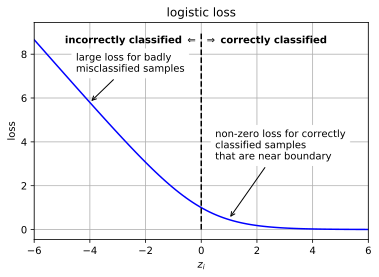

In [10]:
lossfig

- **no closed-form solution**
  - use an iterative optimization algorithm to find the optimal solution
  - e.g. _gradient descent_ - step downhill in each iteration.
    - $\mathbf{w} \leftarrow \mathbf{w} - \eta \frac{d E}{d\mathbf{w}}$
    - where $E$ is the objective function
    - $\eta$ is the _learning rate_ (how far to step in each iteration).

# Example: Iris Data

In [11]:
# load iris data each row is (petal length, sepal width, class)
irisdata = loadtxt('iris2.csv', delimiter=',', skiprows=1)

X = irisdata[:,0:2]  # the first two columns are features (petal length, sepal width)
Y = irisdata[:,2]    # the third column is the class label (versicolor=1, virginica=2) 
                     #  --> automaticaly mapped to (-1, +1) when training classifier

print(X.shape)

(100, 2)


In [12]:
# a colormap for making the scatter plot: class -1 will be red, class +1 will be green
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#FF0000", "#FFFFFF", "#00FF00"])

axbox = [2.5, 7, 1.5, 4] # common axis range

# a function for setting a common plot
def irisaxis(axbox):
    plt.xlabel('petal length'); plt.ylabel('sepal width')
    plt.axis(axbox); plt.grid(True)

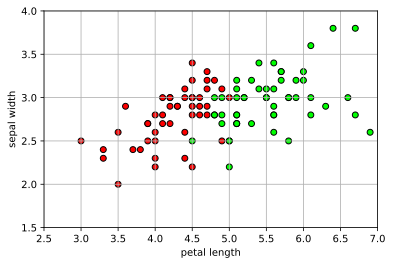

In [13]:
# show the data
plt.figure()
plt.scatter(X[:,0], X[:,1], c=Y, cmap=mycmap, edgecolors='k')
irisaxis(axbox)

In [14]:
# randomly split data into 50% train and 50% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.5, test_size=0.5, random_state=4487)

print(trainX.shape)
print(testX.shape)

(50, 2)
(50, 2)


In [15]:
# learn logistic regression classifier
# (C is a regularization hyperparameter)
logreg = linear_model.LogisticRegression(C=100)
logreg.fit(trainX, trainY)

print("w =", logreg.coef_)
print("b =", logreg.intercept_)

w = [[ 4.87521863 -0.61512848]]
b = [-21.67874573]


- Equation:
  - $f(x) = (4.87 * petal\_length) - (0.62 * sepal\_width) - 21.68$
- Interpretation:
  - large petal length makes f(x) positive, so large petal length is associated with class +1.

In [16]:
def plot_posterior(model, axbox, mycmap, showlabels=True):
    xr = [ linspace(axbox[0], axbox[1], 200), 
           linspace(axbox[2], axbox[3], 200) ]

    # make a grid for calculating the posterior, 
    #  then form into a big [N,2] matrix
    xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
    allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

    # calculate the posterior probability
    post = model.predict_proba(allpts)
    # extract the posterior for class 2, and reshape into a grid
    post1 = post[:,1].reshape(xgrid0.shape)

    # contour plot of the posterior and decision boundary
    plt.imshow(post1, origin='lower', extent=axbox, alpha=0.50, cmap=mycmap, vmin=0.0, vmax=1.0)
    if showlabels:
        plt.colorbar(shrink=0.6)
    CS = plt.contour(xr[0], xr[1], post1, colors='k', linestyles='dashed', levels=[0.1, 0.3, 0.7, 0.9], alpha=0.8, linewidths=1)
    if showlabels:
        #plt.colorbar(CS)
        plt.clabel(CS, inline=1, fontsize=10)
    plt.contour(xr[0], xr[1], post1, levels=[0.5], linewidths=2, colors='black')
    irisaxis(axbox)


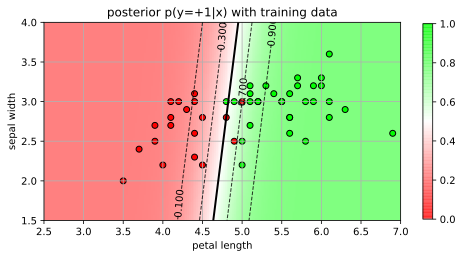

In [17]:
# show the posterior and training data
plt.figure(figsize=(8,6))
plot_posterior(logreg, axbox, mycmap)
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
plt.title('posterior p(y=+1|x) with training data');

In [18]:
# predict from the model
predY = logreg.predict(testX)

# calculate accuracy
acc = metrics.accuracy_score(testY, predY)
print("test accuracy =", acc)

test accuracy = 0.92


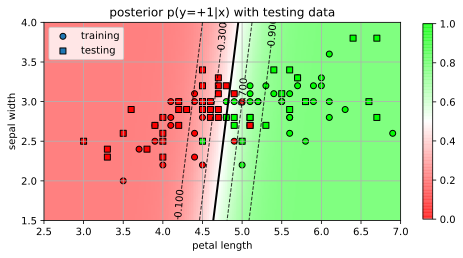

In [19]:
# show the posterior and training data
plt.figure(figsize=(8,6))
plot_posterior(logreg, axbox, mycmap)
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, marker="o", label="training", edgecolors='k')
plt.scatter(testX[:,0], testX[:,1], c=testY, cmap=mycmap, marker="s", label="testing", edgecolors='k')
plt.title('posterior p(y=+1|x) with testing data');
plt.legend(loc=0);

# Selecting the regularization hyperparameter
- the regularization hyperparameter $C$ has a big effect on the decision boundary and the accuracy.
- How to set the value of $C$?

In [20]:
lrC = plt.figure(figsize=(9,6))

allC = [10000,100, 10, 1,0.01, 0.0001]
for (myCind,myC) in enumerate(allC):
    logreg = linear_model.LogisticRegression(C=myC)
    logreg.fit(trainX, trainY)
    
    # predict from the model
    predY = logreg.predict(testX)

    # calculate accuracy
    acc = metrics.accuracy_score(testY, predY)
    
    plt.subplot(2,3,myCind+1)
    plot_posterior(logreg, axbox, mycmap, showlabels=False)
    plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap, edgecolors='k')
    plt.title('C='+str(myC)+"; acc="+str(acc));
    plt.gca().xaxis.set_ticklabels([])
    plt.gca().yaxis.set_ticklabels([])
plt.close()

D:\Anaconda3\lib\site-packages\matplotlib\contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


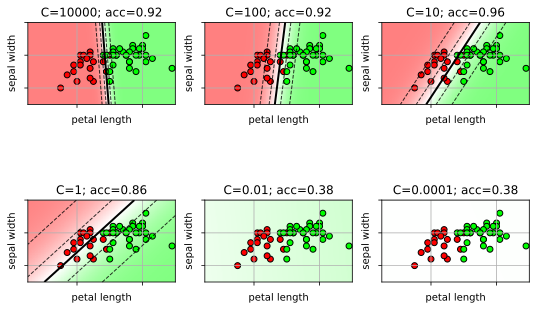

In [21]:
lrC

# Cross-validation
- Use _cross-validation_ on the training set to select the best value of $C$.
- Run many experiments on the training set to see which parameters work on different versions of the data.
  - Split the data into batches of training and validation data.
  - Try a range of $C$ values on each split.
  - Pick the value that works best over all splits.

<center><img src="imgs/10_fold_cv.png" width="500px"/></center>

- **Procedure**
  1. select a range of $C$ values to try
  2. Repeat $K$ times
    1. Split the training set into training data and validation data
    2. Learn a classifier for each value of $C$
    3. Record the accuracy on the validation data for each $C$
  3. Select the value of $C$ that has the highest average accuracy over all $K$ folds.
  4. Retrain the classifier using all data and the selected $C$.

- scikit-learn already has built-in `cross_validation` module (more later).
- for logistic regression, use _LogisticRegressionCV_ class

In [22]:
# learn logistic regression classifier usinc CV
#  Cs is an array of possible C values
#  cv is the number of folds
#  n_jobs is the number of parallel jobs to run (makes it faster)
#    -1 means use all cores
logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, n_jobs=-1)
logreg.fit(trainX, trainY)

print("w=", logreg.coef_)
print("b=", logreg.intercept_)

# predict from the model
predY = logreg.predict(testX)

# calculate accuracy
acc = metrics.accuracy_score(testY, predY)
print("test accuracy=", acc)

w= [[4.61911642 0.72396452]]
b= [-24.24716674]
test accuracy= 0.9


# Which C was selected?

C = [4.2813324]


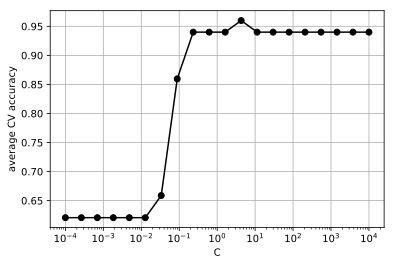

In [23]:
print("C =", logreg.C_)

# calculate the average score for each C
avgscores = mean(logreg.scores_[2],0)  # 2 is the class label
plt.figure()
plt.semilogx(logreg.Cs_, avgscores, 'ko-')
plt.xlabel('C'); plt.ylabel('average CV accuracy')
plt.grid(True);

# Multi-class classification
- So far, we have only learned a classifier for 2 classes (+1, -1)
  - called a **binary classifier**
- For more than 2 classes, split the problem up into several binary classifier problems.
  - **1-vs-rest** 
    - _Training:_ for each class, train a classifier for that class versus the other classes.  
      - For example, if there are 3 classes, then train 3 binary classifiers:  1 vs {2,3}; 2 vs {1,3}; 3 vs {1,2}
    - _Prediction:_ calculate probability for each binary classifier.  Select the class with highest probability.

# Example on 3-class Iris data

In [24]:
# load iris data each row is (petal length, sepal width, class)
irisdata = loadtxt('iris3.csv', delimiter=',', skiprows=1)

X = irisdata[:,0:2]  # the first two columns are features (petal length, sepal width)
Y = irisdata[:,2]    # the third column is the class label (setosa=0, versicolor=1, virginica=2)

print(X.shape)

(150, 2)


In [25]:
# randomly split data into 50% train and 50% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.5, test_size=0.5, random_state=4487)

print(trainX.shape)
print(testX.shape)

(75, 2)
(75, 2)


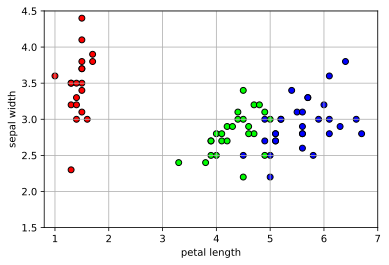

In [26]:
# look at training data

axbox3 = [0.8, 7, 1.5, 4.5]
# make a colormap for viewing 3 classes
mycmap3 = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#FF0000", "#00FF00", "#0000FF"])

plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap3, edgecolors='k')
plt.axis(axbox3); plt.grid(True);
plt.xlabel('petal length'); plt.ylabel('sepal width');

In [27]:
# learn logistic regression classifier (one-vs-all)
mlogreg = linear_model.LogisticRegression(C=10)
mlogreg.fit(trainX, trainY)

# now contains 3 hyperplanes and 3 bias terms (one for each class)
print("w=", mlogreg.coef_)
print("b=", mlogreg.intercept_)

# predict from the model
predY = mlogreg.predict(testX)

# calculate accuracy
acc = metrics.accuracy_score(testY, predY)
print("test accuracy=", acc)

w= [[-3.09131694  2.52132269]
 [ 0.06064355 -1.58022283]
 [ 3.35076433 -3.48981157]]
b= [ 0.73591801  3.79651516 -6.36532274]
test accuracy= 0.9733333333333334


In [28]:
def plot_1vr_classifiers(logreg, mlogreg, axbox, mycmap, trainX, trainY, titstr):
    # plot each classifier (assume 3)
    for i in range(3):
        plt.subplot(1,3,i+1)
        # make binary model
        ilogreg = linear_model.LogisticRegression(logreg)
        ilogreg.coef_ = mlogreg.coef_[i,:].reshape(1,2)
        ilogreg.intercept_ = mlogreg.intercept_[i].reshape(1,) 
        itrainY = (trainY == i)
        
        plot_posterior(ilogreg, axbox, mycmap, showlabels=False)
        plt.scatter(trainX[:,0], trainX[:,1], c=itrainY, cmap=mycmap, edgecolors='k')

        plt.gca().xaxis.set_ticklabels([])
        plt.gca().yaxis.set_ticklabels([])
        plt.title(titstr.format(i))

mlrfig = plt.figure(figsize=(9,6))
plot_1vr_classifiers(logreg, mlogreg, axbox3, mycmap, trainX, trainY, "class {} vs. rest")
plt.close()

- the individual 1-vs-rest binary classifiers

w= [[-3.09131694  2.52132269]
 [ 0.06064355 -1.58022283]
 [ 3.35076433 -3.48981157]]
b= [ 0.73591801  3.79651516 -6.36532274]


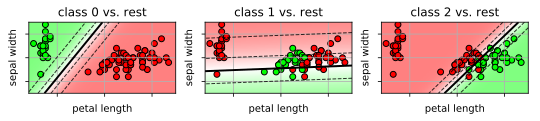

In [29]:
print("w=", mlogreg.coef_)
print("b=", mlogreg.intercept_)

mlrfig 

In [30]:
def plot_posterior3(model, axbox, mycmap):    
    xr = [ arange(0.8,7,0.05) , arange(1.5, 4.5, 0.05) ]
        
    # make a grid for calculating the posterior, 
    #  then form into a big [N,2] matrix
    xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
    allpts = c_[xgrid0.ravel(), xgrid1.ravel()]

    # predict probabilities
    Z = model.predict_proba(allpts)
    P = model.predict(allpts)

    # use probabilities as RGB color
    ZZ = Z.reshape((len(xr[1]), len(xr[0]), 3))

    plt.imshow(ZZ, origin='lower', extent=axbox, alpha=0.50)
    plt.contour(xr[0], xr[1], P.reshape(xgrid0.shape), levels=[0.5,1.5,2.5], linestyles='dashed', colors='black')
    irisaxis(axbox)
    
lr3class = plt.figure()
plot_posterior3(mlogreg, axbox3, mycmap3)
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap3, edgecolors='k')
plt.title('class probabilities');
plt.close()

- the final classifier, combining all 1 vs rest classifiers

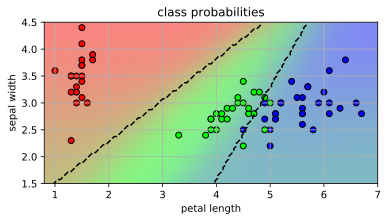

In [31]:
lr3class

# Multiclass logistic regression
- Another way to get a multi-class classifier is to define a multi-class objective.
  - One weight vector $\mathbf{w}_c$ for each class c.
- Define probabilities with **softmax** function
  - analogous to sigmoid function for binary logistic regression.
  - $p(y=c|\mathbf{x}) = \frac{\exp (\mathbf{w}_c^T \mathbf{x})}{\exp (\mathbf{w}_1^T \mathbf{x}) + \cdots + \exp (\mathbf{w}_K^T \mathbf{x})}$
  - The class with largest reponse of $\mathbf{w}_c^T\mathbf{x}$ will have the highest probability.
- Estimate the $\{\mathbf{w}_j\}$ parameters using MLE as before.

In [32]:
# learn logistic regression classifier
mlogreg = linear_model.LogisticRegression(C=10, 
            multi_class='multinomial', solver='lbfgs')  
            # use multi-class and corresponding solver
mlogreg.fit(trainX, trainY)

# now contains 3 hyperplanes and 3 bias terms (one for each class)
print("w=", mlogreg.coef_)
print("b=", mlogreg.intercept_)

# predict from the model
predY = mlogreg.predict(testX)

# calculate accuracy
acc = metrics.accuracy_score(testY, predY)
print("test accuracy=", acc)

w= [[-4.13092437  1.30718735]
 [-0.71717021  0.23609022]
 [ 4.84809458 -1.54327757]]
b= [ 11.46078594   5.40723484 -16.86802078]
test accuracy= 0.9733333333333334


In [33]:
lr3classm = plt.figure()
plot_posterior3(mlogreg, axbox3, mycmap3)
plt.scatter(trainX[:,0], trainX[:,1], c=trainY, cmap=mycmap3, edgecolors='k')
plt.title('class probabilities');
plt.close()

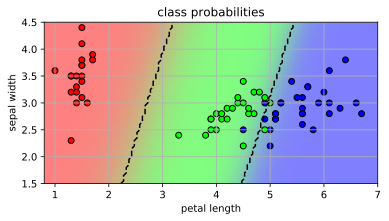

In [34]:
lr3classm

In [35]:
lr31vr = plt.figure(figsize=(9,6))
plot_1vr_classifiers(logreg, mlogreg, axbox3, mycmap, trainX, trainY, "w{}")
plt.close()

D:\Anaconda3\lib\site-packages\matplotlib\contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


- individual weight vectors work together to partition the space

w= [[-4.13092437  1.30718735]
 [-0.71717021  0.23609022]
 [ 4.84809458 -1.54327757]]
b= [ 11.46078594   5.40723484 -16.86802078]


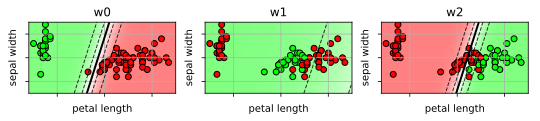

In [36]:
print("w=", mlogreg.coef_)
print("b=", mlogreg.intercept_)

lr31vr

# Logistic Regression Summary
- **Classifier:**
  - linear function $f(\mathbf{x}) = \mathbf{w}^T\mathbf{x} + b$
  - Given a feature vector $\mathbf{x}$, the probability of a class is:
    - $p(y=+1|\mathbf{x}) = \sigma( f(\mathbf{x}) )$
    - $p(y=-1|\mathbf{x}) = 1-\sigma( f(\mathbf{x}) )$
    - _sigmoid_ function: $\sigma(z) = \frac{1}{1+e^{-z}}$
  - logistic loss function: $L(z) = \log (1+\exp(-z))$
- **Training:**
  - Maximize the likelihood of the training data.
  - Use regularization to prevent overfitting.
    - Use cross-validation to pick the regularization hyperparameter $C$.

- **Classification:**
  - Given a new sample $\mathbf{x}^*$:
    - pick class with highest probability $p(y|\mathbf{x}^*)$:
      - $y^* = \begin{cases}+1, p(y=+1|\mathbf{x}^*)>p(y=-1|\mathbf{x}^*) \\ -1, \mathrm{otherwise}\end{cases}$
    - alternatively, just use $f(\mathbf{x}^*)$
      - $y^* = \begin{cases}+1, f(\mathbf{x}^*)>0 \\ -1, \mathrm{otherwise}\end{cases} = \mathrm{sign}(f(\mathbf{x}_*))$